# Загрузка Pandas

In [1]:
# Импортируем необходимые библиотеки:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import re
import requests
import string
from bs4 import BeautifulSoup
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Для воспроизводимости результатов:
random_seed = 42 # Общий параметр для генерации случайных чисел
current_date = pd.to_datetime('26/01/2021') # Общая текущуя дата
!pip freeze > requirements.txt # Для тех, кто будет запускать мой ноутбук на своей машине
                               #создаем requirements.txt

# Анализ исходных данных

In [3]:
# Загрузим датасеты
mt_data = pd.read_csv('main_task.csv')
kt_data = pd.read_csv('kaggle_task.csv')
mt_data.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781


In [4]:
mt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
kt_data.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638


In [6]:
kt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [7]:
# Рассмотрим последние два стролбца ДФ.
print('URL_TA[0]  ', mt_data['URL_TA'][0], '\n\n', 'ID_TA[0]  ', mt_data['ID_TA'][0], sep = '')

# URL_TA очевидно ссылка на ресторан на Tripadvisor
# ID_TA судя по всему - id ресторана в системе Tripadvisor, так как присутствует в ссылке
# на ресторан

print('\nУникальных ID_TA', mt_data['ID_TA'].nunique())

# судя по всему, в данных есть задвоение ресторанов, найдем их

rest_id_ta = mt_data['ID_TA'].value_counts(sort = True, ascending = False)
print('\nУникальные значения rest_id_ta', rest_id_ta.unique())
print('\nКоличество задвоений', len(rest_id_ta.loc[rest_id_ta == 2]))

URL_TA[0]  /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html

ID_TA[0]  d1912643

Уникальных ID_TA 39980

Уникальные значения rest_id_ta [2 1]

Количество задвоений 20


In [8]:
# Как видно, 20 ресторанов представлены в ДФ дважды, убедимся что это именно одинаковые строки
mt_data[(mt_data['ID_TA'] == 'd2477531')
        | (mt_data['ID_TA'] == 'd7342803')
        | (mt_data['ID_TA'] == 'd697406')]

# Все не так однозначно - все колонки одинаковые, кроме 'Ranking' и 'Restaurant_id'
# учитывая столь большие сходства будем считать эти строки дубликатами и уберем лишние

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
4578,id_1180,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...",1181.0,4.0,$$ - $$$,341.0,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406
8421,id_3811,Madrid,['Spanish'],3813.0,4.0,$,23.0,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531
22924,id_2359,Madrid,"['Spanish', 'Mediterranean']",2361.0,4.5,$$ - $$$,16.0,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803
24545,id_3805,Madrid,['Spanish'],3807.0,4.0,$,23.0,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531
28096,id_1209,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...",1210.0,4.0,$$ - $$$,341.0,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406
36275,id_2467,Madrid,"['Spanish', 'Mediterranean']",2469.0,4.5,$$ - $$$,16.0,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803


In [9]:
# Рассмотрим последние два стролбца в ДФ kaggle_task.
print('URL_TA[0]  ', kt_data['URL_TA'][0], '\n\n', 'ID_TA[0]  ', kt_data['ID_TA'][0], sep = '')

# URL_TA очевидно ссылка на ресторан на Tripadvisor
# ID_TA судя по всему - id ресторана в системе Tripadvisor, так как присутствует в ссылке
# на ресторан

print('\nУникальных ID_TA', kt_data['ID_TA'].nunique())

# В этом ДФ задвоения ресторанов нет

URL_TA[0]  /Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html

ID_TA[0]  d10746918

Уникальных ID_TA 10000


In [10]:
# Объединим ДФ main и kaggle для проведения предобработки.
# В ДФ kaggle добавим столбец 'Rating' со значением 0
# Для различения датафреймов добавим стобец 'Main'
mt_data['Main'] = 1
kt_data['Main'] = 0
kt_data['Rating'] = 0
df = mt_data.append(kt_data, sort = False).reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Rating             50000 non-null  float64
 5   Price Range        32639 non-null  object 
 6   Number of Reviews  46800 non-null  float64
 7   Reviews            49998 non-null  object 
 8   URL_TA             50000 non-null  object 
 9   ID_TA              50000 non-null  object 
 10  Main               50000 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [11]:
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1


In [12]:
# Предполагая, что свои 'ID_TA' Tripadvisor назначает в порядке добавления ресторана в систему,
# переведем параметр в числовой и будет использовать в расчетной модели
df['ID_TA'] = df['ID_TA'].apply(lambda x: int(x[1:]))
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,1
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,1


# Создадим признак - количество ресторанов в городе

In [13]:
# Количетсво уникальных городов в ДФ
df['City'].nunique()

31

In [14]:
# Количество уникальных id ресторанов в ДФ
df['Restaurant_id'].nunique()
# Оказывается есть рестораны оцененные несколько раз

13094

In [15]:
df[df['Restaurant_id'] == 'id_1535']
# Видимо параметр 'Restaurant_id' не является общим для всей выборки так как нет повторяющихся
# городов, то есть параметр применяется для каждой страны отдельно, таким образом в ДФ
# представлены 40000 уникальных ресторанов

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,1
3784,id_1535,Edinburgh,"['Italian', 'Pizza', 'Fast Food']",1540.0,3.5,$$ - $$$,44.0,"[['Tasty, tasty...very, very tasty!', 'Really ...",/Restaurant_Review-g186525-d787349-Reviews-Ani...,787349,1
14405,id_1535,Milan,"['Mediterranean', 'European', 'Italian', 'Vege...",1537.0,4.0,$$$$,76.0,"[['Excellent food and service', 'Beautifully p...",/Restaurant_Review-g187849-d6207168-Reviews-Pa...,6207168,1
14740,id_1535,Amsterdam,"['Japanese', 'Asian', 'Sushi']",1538.0,4.0,$$ - $$$,33.0,"[['100 percent authentic Japanese food', 'If y...",/Restaurant_Review-g188590-d1125091-Reviews-Or...,1125091,1
19676,id_1535,Brussels,"['Belgian', 'Fast Food', 'European']",1536.0,3.5,$,87.0,"[['Dec. 27', 'This was really busy'], ['01/03/...",/Restaurant_Review-g188644-d7981538-Reviews-Ma...,7981538,1
20282,id_1535,Paris,['Vegetarian Friendly'],1536.0,5.0,$,25.0,"[['Great food, great vibes'], ['12/16/2017']]",/Restaurant_Review-g187147-d5804392-Reviews-Fr...,5804392,1
22204,id_1535,Warsaw,['Italian'],1537.0,4.0,$$ - $$$,16.0,"[[""5 star is not enough . If I could I'd give....",/Restaurant_Review-g274856-d6001559-Reviews-He...,6001559,1
22367,id_1535,Budapest,"['European', 'Hungarian']",1536.0,4.5,NaN,2.0,"[['Great food for your money!'], ['08/25/2015']]",/Restaurant_Review-g274887-d8564418-Reviews-Eb...,8564418,1
23288,id_1535,Dublin,"['Asian', 'Chinese', 'Thai']",1539.0,3.5,$$ - $$$,37.0,"[['Tasty & Fresh', 'Over priced food'], ['11/1...",/Restaurant_Review-g186605-d4699987-Reviews-Za...,4699987,1
39336,id_1535,Zurich,"['Austrian', 'Swiss', 'International', 'Europe...",1541.0,5.0,$$ - $$$,2.0,"[[], []]",/Restaurant_Review-g188113-d12652562-Reviews-B...,12652562,1


In [16]:
# Создаю словарь с количеством ресторанов в каждом городе
restaurant_count = {}
for city in df['City']:
    if city not in restaurant_count:
        restaurant_count[city] = 1
    else:
        restaurant_count[city] += 1
restaurant_count

{'Paris': 6108,
 'Stockholm': 1033,
 'London': 7193,
 'Berlin': 2705,
 'Munich': 1145,
 'Oporto': 642,
 'Milan': 2694,
 'Bratislava': 380,
 'Vienna': 1443,
 'Rome': 2589,
 'Barcelona': 3395,
 'Madrid': 3813,
 'Dublin': 836,
 'Brussels': 1314,
 'Zurich': 685,
 'Warsaw': 925,
 'Budapest': 1021,
 'Copenhagen': 819,
 'Amsterdam': 1372,
 'Lyon': 1126,
 'Hamburg': 1186,
 'Lisbon': 1647,
 'Prague': 1816,
 'Oslo': 488,
 'Helsinki': 475,
 'Edinburgh': 745,
 'Geneva': 590,
 'Ljubljana': 222,
 'Athens': 776,
 'Luxembourg': 263,
 'Krakow': 554}

In [17]:
df['Rest. Count'] = df['City'].map(restaurant_count)
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Rest. Count
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,1,6108
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,1,1033
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,1,7193


# Создадим признак - относительный ранг

In [18]:
df['Relative Ranking'] = df['Ranking'] / df['Rest. Count']
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Rest. Count,Relative Ranking
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,1,6108,0.911919
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,1,1033,1.487899
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,1,7193,0.049075


# Создадим признак - ценовой ранг

In [19]:
print(df['Price Range'].unique(), df['Price Range'].value_counts(), sep = '\n\n')
# В ДФ рестораны разбиты на 3 ценовых диапазона от самого дешевого '$' до самого дорогого
# '$$$$'. Неизвестные данные примем как среднюю ценовую группу '$$-$$$', так как он наиболее
# часто встречается и добавим столбец dummy-параметра о том, приведен ли параметр
# 'Price Range' в ДФ (False), или нет (True).

['$$ - $$$' nan '$$$$' '$']

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64


In [20]:
df['P.R. nan'] = df['Price Range'].isna()
df['Price Range'] = df['Price Range'].apply(lambda x: 
                                            1 if x == '$' else (5 if x == '$$$$' else 3))
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Rest. Count,Relative Ranking,P.R. nan
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,3,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,1,6108,0.911919,False
1,id_1535,Stockholm,NaN,1537.0,4.0,3,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,1,1033,1.487899,True
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,5,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,1,7193,0.049075,False


# Заполним несдостающие данные в графе 'Number of Reviews'

In [21]:
# Поскольку для всех ресторанов представлены отзывы (параметры URL_TA и ID_TA не имеют
# пропусков), то недостающие значения параметра 'Number of Reviews' заполним средним
# арифметическим с добавлением dummy-параметра
df['NoR nan'] = df['Number of Reviews'].isna()
df['Number of Reviews'] = df['Number of Reviews'].fillna(df['Number of Reviews'].mean())
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Rest. Count,Relative Ranking,P.R. nan,NoR nan
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,3,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,1,6108,0.911919,False,False
1,id_1535,Stockholm,NaN,1537.0,4.0,3,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,1,1033,1.487899,True,False
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,5,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,1,7193,0.049075,False,False


# Создадим признак - является ли город столицей

In [22]:
# Создадим словарь с данными о каждом городе, в котором собрана информация о:
# названии страны (анг.)[0], названии страны (рус.)[1], статусе столицы [2],
# населении города [3], количестве туристов [5]. Названия стран и городов пригодятся
# в дальнейшем для парсинга данных. Население городов и количество туристов в стране
# изначально парсил по таблицам ООН и Международной туристической организации,
# но в таком случае очень долго обрабатыватся таблицы, так что добавил в этот словарь.

cities_data = {
    'Paris': ['France', 'Франция', True, 2206488, 89322],
    'Stockholm': ['Sweden', 'Швеция', True, 789024, 10522],
    'London': ['United Kingdom', 'Великобритания', True, 8135667, 36316],
    'Berlin': ['Germany', 'Германия', True, 3613495, 38881],
    'Munich': ['Germany', 'Германия', False, 1456039, 38881],
    'Oporto': ['Portugal', 'Португалия', False, 214353, 16186],
    'Milan': ['Italy', 'Италия', False, 1358871, 61567],
    'Bratislava': ['Slovakia', 'Словакия', True, 427744, 7620],
    'Vienna': ['Austria', 'Австрия', True, 1888776, 30816],
    'Rome': ['Italy', 'Италия', True, 2873147, 61567],
    'Barcelona': ['Spain', 'Испания', False, 1620576, 82773],
    'Madrid': ['Spain', 'Испания', True, 3203157, 82773],
    'Dublin': ['Ireland', 'Ирландия', True, 544107, 10926],
    'Brussels': ['Belgium', 'Бельгия', True, 174383, 9119],
    'Zurich': ['Switzerland', 'Швейцария', False, 415367, 11715],
    'Warsaw': ['Poland', 'Польша', True, 1754511, 19622],
    'Budapest': ['Hungary', 'Венгрия', True, 1751219, 17552],
    'Copenhagen': ['Denmark', 'Дания', True, 616098, 12749],
    'Amsterdam': ['Netherlands', 'Нидерланды', True, 821752, 18780],
    'Lyon': ['France', 'Франция', False, 513275, 89322],
    'Hamburg': ['Germany', 'Германия', False, 1830584, 38881],
    'Lisbon': ['Portugal', 'Португалия', True, 505526, 16186],
    'Prague': ['Czech Republic (Czechia)', 'Чехия', True, 1294513, 13665],
    'Oslo': ['Norway', 'Норвегия', True, 634293, 5688],
    'Helsinki': ['Finland', 'Финляндия', True, 639227, 3224],
    'Edinburgh': ['United Kingdom', 'Великобритания', False, 482005, 36316],
    'Geneva': ['Switzerland', 'Швейцария', False, 201818, 11715],
    'Ljubljana': ['Slovenia', 'Словения', True, 279650, 4425],
    'Athens': ['Greece', 'Греция', True, 664046, 30123],
    'Luxembourg': ['Luxembourg', 'Люксембург', True, 116323, 1018],
    'Krakow': ['Poland', 'Польша', False, 759104, 19622]
}

In [23]:
df['Capital'] = df['City'].apply(lambda x: cities_data[x][2])
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Rest. Count,Relative Ranking,P.R. nan,NoR nan,Capital
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,3,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,1,6108,0.911919,False,False,True
1,id_1535,Stockholm,NaN,1537.0,4.0,3,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,1,1033,1.487899,True,False,True
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,5,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,1,7193,0.049075,False,False,True


# Добавим данные о кухнях

## Приведем данные в столбце 'Cuisine Style' в доступный для обработки вид

In [24]:
print(df['Cuisine Style'][0], type(df['Cuisine Style'][0]))
# Данные в столбце 'Cuisine Style' представлены в виде списка, который оформлен в строку
# Сначала заполним пустоты аналогичной строкой '[]', добавим dummy-параметр для пустых
# данных, приведем данные к типу list

['European', 'French', 'International'] <class 'str'>


In [25]:
df['CS nan'] = df['Cuisine Style'].isna()
df['Cuisine Style'] = df['Cuisine Style'].fillna('[]')
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: eval(x))
print(df['Cuisine Style'][0], type(df['Cuisine Style'][0]))

['European', 'French', 'International'] <class 'list'>


In [26]:
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Rest. Count,Relative Ranking,P.R. nan,NoR nan,Capital,CS nan
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,3,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,1,6108,0.911919,False,False,True,False
1,id_1535,Stockholm,[],1537.0,4.0,3,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,1,1033,1.487899,True,False,True,True
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,5,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,1,7193,0.049075,False,False,True,False


## Добавим данные о количестве кухонь, представленных в ресторане

In [27]:
# Для пустых значений примеем 1
df['Cuisine Count'] = df['Cuisine Style'].apply(lambda x: len(x) if len(x) > 0 else 1)
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Rest. Count,Relative Ranking,P.R. nan,NoR nan,Capital,CS nan,Cuisine Count
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,3,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,1,6108,0.911919,False,False,True,False,3
1,id_1535,Stockholm,[],1537.0,4.0,3,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,1,1033,1.487899,True,False,True,True,1
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,5,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,1,7193,0.049075,False,False,True,False,7


## Добавим данные о уникальных кухнях

In [28]:
#Составляю список кухонь
cuisine_iter = tuple([set(x) for x in df['Cuisine Style']])
cuisine_set = sorted(set.union(*cuisine_iter))
len(cuisine_set)

125

In [29]:
# Считаю, сколько раз представлена в ДФ каждая кухня
cuisine_set_count = {}
for cuisine in cuisine_set:
    cuisine_set_count[cuisine] = 0
    for row in df['Cuisine Style']:
        if cuisine in row:
            cuisine_set_count[cuisine] += 1
cuisine_set_count = pd.DataFrame(data = [*cuisine_set_count.items()],
                                 columns = ['Cuisine', 'Count'])
cuisine_set_count.sort_values(by = ['Count'], ascending = False)

,Cuisine,Count
118,Vegetarian Friendly,14021
44,European,12561
74,Mediterranean,7820
65,Italian,7433
117,Vegan Options,5684
...,...,...
124,Yunnan,2
19,Burmese,1
71,Latvian,1
94,Salvadoran,1


In [30]:
# Создаю список кухонь, представленных единожды в ДФ
unique_cuisine = list(cuisine_set_count[cuisine_set_count['Count'] == 1]['Cuisine'])
unique_cuisine

['Burmese', 'Latvian', 'Salvadoran', 'Xinjiang']

In [31]:
#Создаю функцию определения наличия уникальной кухни в ресторане
def Unique_Cuisine(data):
    result = 0
    for cuisine in unique_cuisine:
        if cuisine in data:
            result = 1
    return result
     
#Добавляю столбец параметов уникальных кухонь    
df['Unique Cuisine'] = df['Cuisine Style'].apply(lambda x: Unique_Cuisine(x))
df[df['Unique Cuisine'] == 1]

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Rest. Count,Relative Ranking,P.R. nan,NoR nan,Capital,CS nan,Cuisine Count,Unique Cuisine
10858,id_1965,Madrid,"[Mexican, Latin, Salvadoran, Central American,...",1967.0,4.0,3,280.0,"[['Excellent flamenco show', 'Average mexican'...",/Restaurant_Review-g187514-d6656786-Reviews-So...,6656786,1,3813,0.515867,False,False,True,False,5,1
22130,id_6375,Paris,"[Chinese, Xinjiang]",6376.0,4.0,3,41.0,"[['Awsome and highly recommended', 'This bring...",/Restaurant_Review-g187147-d5017904-Reviews-Mu...,5017904,1,6108,1.043877,False,False,True,False,2,1
22961,id_7467,London,"[Chinese, Asian, Thai, Burmese]",7476.0,5.0,1,5.0,[['Have to go back again soon - delicious foo....,/Restaurant_Review-g186338-d12870156-Reviews-V...,12870156,1,7193,1.039344,False,False,True,False,4,1
37919,id_1129,Budapest,"[Mexican, American, European, Latvian, Eastern...",1130.0,5.0,1,5.0,"[['What a great idea', 'Hit and miss'], ['03/0...",/Restaurant_Review-g274887-d11864784-Reviews-F...,11864784,1,1021,1.106758,False,False,True,False,6,1


# Добавляем данные о отзывах

## Даты отзывов

In [32]:
# Смотрим содержание в столбце 'Reviews'
df['Reviews'][0]
# Можно извлеч даты последнего и предпоследнего отзыва, определить разницу во времени
# между отзывами, разницу между последним отзывом и текущей датой

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

In [33]:
# Сперва заполним пропуски в данных
df['Reviews'] = df['Reviews'].fillna('[[], []]')

In [34]:
# Создаю отдельный датафрейм из дат отзывов и расчетом разницы между этими датами
pattern = re.compile('\d{2}/\d{2}/\d{4}')
reviews = []
for i in df['Reviews']:
    reviews.append(re.findall(pattern, i))
rev = pd.DataFrame(reviews)
rev.columns = ['date1', 'date2']
rev['date1'] = pd.to_datetime(rev['date1']) 
rev['date2'] = pd.to_datetime(rev['date2']) 
rev['TD Reviews'] = (rev['date1'] - rev['date2']).dt.days
rev['Last Review'] = (current_date - rev['date1']).dt.days
rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date1        41886 non-null  datetime64[ns]
 1   date2        36206 non-null  datetime64[ns]
 2   TD Reviews   36206 non-null  float64       
 3   Last Review  41886 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 1.5 MB


In [35]:
# Пропуски в столбцах 'Deta Reviews' и 'Last Review' заполним средними значениями
rev['TD Reviews'] = rev['TD Reviews'].fillna(round(rev['TD Reviews'].mean()))
rev['Last Review'] = rev['Last Review'].fillna(round(rev['Last Review'].mean()))

# Добавим полученные данные в ДФ:
df['TD Reviews'] = rev['TD Reviews']
df['Last Review'] = rev['Last Review']
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Rest. Count,Relative Ranking,P.R. nan,NoR nan,Capital,CS nan,Cuisine Count,Unique Cuisine,TD Reviews,Last Review
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,3,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,...,6108,0.911919,False,False,True,False,3,0,41.0,1122.0
1,id_1535,Stockholm,[],1537.0,4.0,3,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,...,1033,1.487899,True,False,True,True,1,0,382.0,1300.0
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,5,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,...,7193,0.049075,False,False,True,False,7,0,2.0,1114.0


## Слова из отзывов

Попробуем использовать слова, содержащиеся в отзывах, для чего создадим словарь всех слов

In [36]:
def remove_chars_from_text(text):
    spec_chars = string.punctuation + '\n\xa0«»\t—…0123456789'
    return ''.join([ch.lower() for ch in text if ch not in spec_chars])

df['Reviews'] = df['Reviews'].map(remove_chars_from_text)

In [37]:
# Загружаем список позитивных слов
pos_words = []
with open('positive-words.txt', 'r') as f:
    for line in f:
        pos_words.append(line[:-1])

# Загружаем список негативных слов
neg_words = []
with open('neg_words.txt', 'r') as f:
    for line in f:
        neg_words.append(line[:-1])

In [38]:
# Создаем список уникальных слов из отзывов
def count_words(text, words):
    pattern = re.compile('\w{3,}')
    return len([i for i in re.findall('\w{3,}', text) if i in words])

df['Positive words'] = df['Reviews'].apply(lambda x: count_words(x, pos_words))
df['Negative words'] = df['Reviews'].apply(lambda x: count_words(x, neg_words))
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,P.R. nan,NoR nan,Capital,CS nan,Cuisine Count,Unique Cuisine,TD Reviews,Last Review,Positive words,Negative words
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,3,194.0,good food at your doorstep a good hotel restau...,/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,...,False,False,True,False,3,0,41.0,1122.0,2,0
1,id_1535,Stockholm,[],1537.0,4.0,3,10.0,unique cuisine delicious nepalese food,/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,...,True,False,True,True,1,0,382.0,1300.0,1,0
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,5,688.0,catch up with friends not exceptional,/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,...,False,False,True,False,7,0,2.0,1114.0,1,0


# 8. Добавляем данные о населении

## 8.1 Добавляем данные о населении страны

In [39]:
# Данные о населении страны нашел на worldometers.info
url = 'https://www.worldometers.info/world-population/population-by-country/'
response = requests.get(url)
page = BeautifulSoup(requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).text, 'html.parser')

In [40]:
# Загружаем таблицу
all_blocks = page.find_all('div', class_='table-responsive')
data_html = all_blocks[0].find('table')
population_data = pd.read_html(str(data_html))[0]  
population_data.head(3)

,#,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,1,China,1439323776,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,2,India,1380004385,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,3,United States,331002651,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %


In [41]:
# Создаю функцию, извлекающую данные из таблицы по названию города
def Population_Data(city):
    df = {}
    # В таблице приведены данные для страны, в исследуемом ДФ приведены города
    # Название страны получим используюя ранее созданный словарь cities_data
    country = cities_data[city][0]
    data = population_data[population_data['Country (or dependency)'] == country]
    df[country] = [data['Population (2020)'].values[0], # Население
                   data['Density (P/Km²)'].values[0],  # Плотность населения
                   float(data['Med. Age'].values[0]), # Медианный возраст населения
                   float(data['Urban Pop %'].values[0][:-2])] # Урбанизация
    return df

population_df = {}
for city in cities_data:
    if cities_data[city][0] not in population_df:
        population_df.update(Population_Data(city))
population_df

{'France': [65273511, 119, 42.0, 82.0],
 'Sweden': [10099265, 25, 41.0, 88.0],
 'United Kingdom': [67886011, 281, 40.0, 83.0],
 'Germany': [83783942, 240, 46.0, 76.0],
 'Portugal': [10196709, 111, 46.0, 66.0],
 'Italy': [60461826, 206, 47.0, 69.0],
 'Slovakia': [5459642, 114, 41.0, 54.0],
 'Austria': [9006398, 109, 43.0, 57.0],
 'Spain': [46754778, 94, 45.0, 80.0],
 'Ireland': [4937786, 72, 38.0, 63.0],
 'Belgium': [11589623, 383, 42.0, 98.0],
 'Switzerland': [8654622, 219, 43.0, 74.0],
 'Poland': [37846611, 124, 42.0, 60.0],
 'Hungary': [9660351, 107, 43.0, 72.0],
 'Denmark': [5792202, 137, 42.0, 88.0],
 'Netherlands': [17134872, 508, 43.0, 92.0],
 'Czech Republic (Czechia)': [10708981, 139, 43.0, 74.0],
 'Norway': [5421241, 15, 40.0, 83.0],
 'Finland': [5540720, 18, 43.0, 86.0],
 'Slovenia': [2078938, 103, 45.0, 55.0],
 'Greece': [10423054, 81, 46.0, 85.0],
 'Luxembourg': [625978, 242, 40.0, 88.0]}

In [42]:
# Добавляем новые параметры в ДФ
df['Population'] = df['City'].apply(lambda x: population_df[cities_data[x][0]][0])
df['Density'] = df['City'].apply(lambda x: population_df[cities_data[x][0]][1])
df['Med. Age'] = df['City'].apply(lambda x: population_df[cities_data[x][0]][2])
df['Urban Pop. %'] = df['City'].apply(lambda x: population_df[cities_data[x][0]][3])
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Cuisine Count,Unique Cuisine,TD Reviews,Last Review,Positive words,Negative words,Population,Density,Med. Age,Urban Pop. %
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,3,194.0,good food at your doorstep a good hotel restau...,/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,...,3,0,41.0,1122.0,2,0,65273511,119,42.0,82.0
1,id_1535,Stockholm,[],1537.0,4.0,3,10.0,unique cuisine delicious nepalese food,/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,...,1,0,382.0,1300.0,1,0,10099265,25,41.0,88.0
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,5,688.0,catch up with friends not exceptional,/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,...,7,0,2.0,1114.0,1,0,67886011,281,40.0,83.0


## 8.2 Добавляем данные о населении города

In [43]:
# Дополняю ДФ данными о населении города из словаря cities_data
df['City Pop.'] = df['City'].apply(lambda x: cities_data[x][3])
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Unique Cuisine,TD Reviews,Last Review,Positive words,Negative words,Population,Density,Med. Age,Urban Pop. %,City Pop.
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,3,194.0,good food at your doorstep a good hotel restau...,/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,...,0,41.0,1122.0,2,0,65273511,119,42.0,82.0,2206488
1,id_1535,Stockholm,[],1537.0,4.0,3,10.0,unique cuisine delicious nepalese food,/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,...,0,382.0,1300.0,1,0,10099265,25,41.0,88.0,789024
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,5,688.0,catch up with friends not exceptional,/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,...,0,2.0,1114.0,1,0,67886011,281,40.0,83.0,8135667


# 9. Добавляем экономические данные

In [44]:
# Находим данные о размере ВВП стран по паритету покупательной способности
url_gdp = 'https://nonews.co/directory/lists/countries/gdp-ppp'
page = BeautifulSoup(requests.get(url_gdp, headers={'User-Agent': 'Mozilla/5.0'}).text, 'html.parser')

In [45]:
# Извлекаем таблицу со страницы сайта
all_blocks = page.find_all('div', class_='tab_widget wp_shortcodes_tabs')
data_html = all_blocks[0].find('table')
gdp_data = pd.read_html(str(data_html))[0]
gdp_data.head(3)

,№,Страна,ВВП (дол. США)
0,1,Китай,22 526 559 322 400
1,2,США,20 574 972 485 307
2,3,Индия,9 229 177 053 611


In [46]:
# Создаю функцию для извлечения данных из таблицы по наименованию города
def GDP_Data(city):
    country = cities_data[city][1]
    data = gdp_data[gdp_data['Страна'] == country]
    gdp = data['ВВП (дол. США)'].values[0]
    return int(''.join([x for x in (gdp).split()]))

In [47]:
# Добавляю параметр ВВП ('GDP') и ВВП на душу населения рассчитываю ('GDP/Pop')
df['GDP'] = df['City'].apply(lambda x: GDP_Data(x))
df['GDP/Pop.'] = df['GDP'] / df['Population']
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Last Review,Positive words,Negative words,Population,Density,Med. Age,Urban Pop. %,City Pop.,GDP,GDP/Pop.
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,3,194.0,good food at your doorstep a good hotel restau...,/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,...,1122.0,2,0,65273511,119,42.0,82.0,2206488,3097061752487,47447.451578
1,id_1535,Stockholm,[],1537.0,4.0,3,10.0,unique cuisine delicious nepalese food,/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,...,1300.0,1,0,10099265,25,41.0,88.0,789024,547238102912,54185.933621
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,5,688.0,catch up with friends not exceptional,/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,...,1114.0,1,0,67886011,281,40.0,83.0,8135667,3121120096107,45975.894741


# 10. Добавляем данные о туризме

In [48]:
# Добавляю данные о количестве туристов 'Tourism' из словаря cities_data и туристов на душу населения 'Tourism/Pop.'
df['Tourism'] = df['City'].apply(lambda x: cities_data[x][4])
df['Tourism/Pop.'] = df['Tourism'] / df['Population']
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Negative words,Population,Density,Med. Age,Urban Pop. %,City Pop.,GDP,GDP/Pop.,Tourism,Tourism/Pop.
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,3,194.0,good food at your doorstep a good hotel restau...,/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,...,0,65273511,119,42.0,82.0,2206488,3097061752487,47447.451578,89322,0.001368
1,id_1535,Stockholm,[],1537.0,4.0,3,10.0,unique cuisine delicious nepalese food,/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,...,0,10099265,25,41.0,88.0,789024,547238102912,54185.933621,10522,0.001042
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,5,688.0,catch up with friends not exceptional,/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,...,0,67886011,281,40.0,83.0,8135667,3121120096107,45975.894741,36316,0.000535


# 11. Добавляем производные параметры

In [49]:
# Добавляем признак количество людей на ресторан в городе
df['People Per Rest.'] = df['City Pop.'] / df['Rest. Count']

# Добавляем признак количество туристов на ресторан в городе
df['Tourist Per Rest.'] = df['Tourism'] / df['Rest. Count']

# Добавляем признак количество отзывов на население города
df['Reviews per C.Pop.'] = df['Number of Reviews'] / df['City Pop.']

# Добавляем признак количество отзывов на количество туристов
df['Reviews per Tourism'] = df['Number of Reviews'] / df['Tourism']

df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Urban Pop. %,City Pop.,GDP,GDP/Pop.,Tourism,Tourism/Pop.,People Per Rest.,Tourist Per Rest.,Reviews per C.Pop.,Reviews per Tourism
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,3,194.0,good food at your doorstep a good hotel restau...,/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,...,82.0,2206488,3097061752487,47447.451578,89322,0.001368,361.245580,14.623772,0.000088,0.002172
1,id_1535,Stockholm,[],1537.0,4.0,3,10.0,unique cuisine delicious nepalese food,/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,...,88.0,789024,547238102912,54185.933621,10522,0.001042,763.818006,10.185866,0.000013,0.000950
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,5,688.0,catch up with friends not exceptional,/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,...,83.0,8135667,3121120096107,45975.894741,36316,0.000535,1131.053385,5.048797,0.000085,0.018945


# 11. Проверим ДФ

In [50]:
# Проверяем перед добавлением dummy-параметров
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant_id        50000 non-null  object 
 1   City                 50000 non-null  object 
 2   Cuisine Style        50000 non-null  object 
 3   Ranking              50000 non-null  float64
 4   Rating               50000 non-null  float64
 5   Price Range          50000 non-null  int64  
 6   Number of Reviews    50000 non-null  float64
 7   Reviews              50000 non-null  object 
 8   URL_TA               50000 non-null  object 
 9   ID_TA                50000 non-null  int64  
 10  Main                 50000 non-null  int64  
 11  Rest. Count          50000 non-null  int64  
 12  Relative Ranking     50000 non-null  float64
 13  P.R. nan             50000 non-null  bool   
 14  NoR nan              50000 non-null  bool   
 15  Capital              50000 non-null 

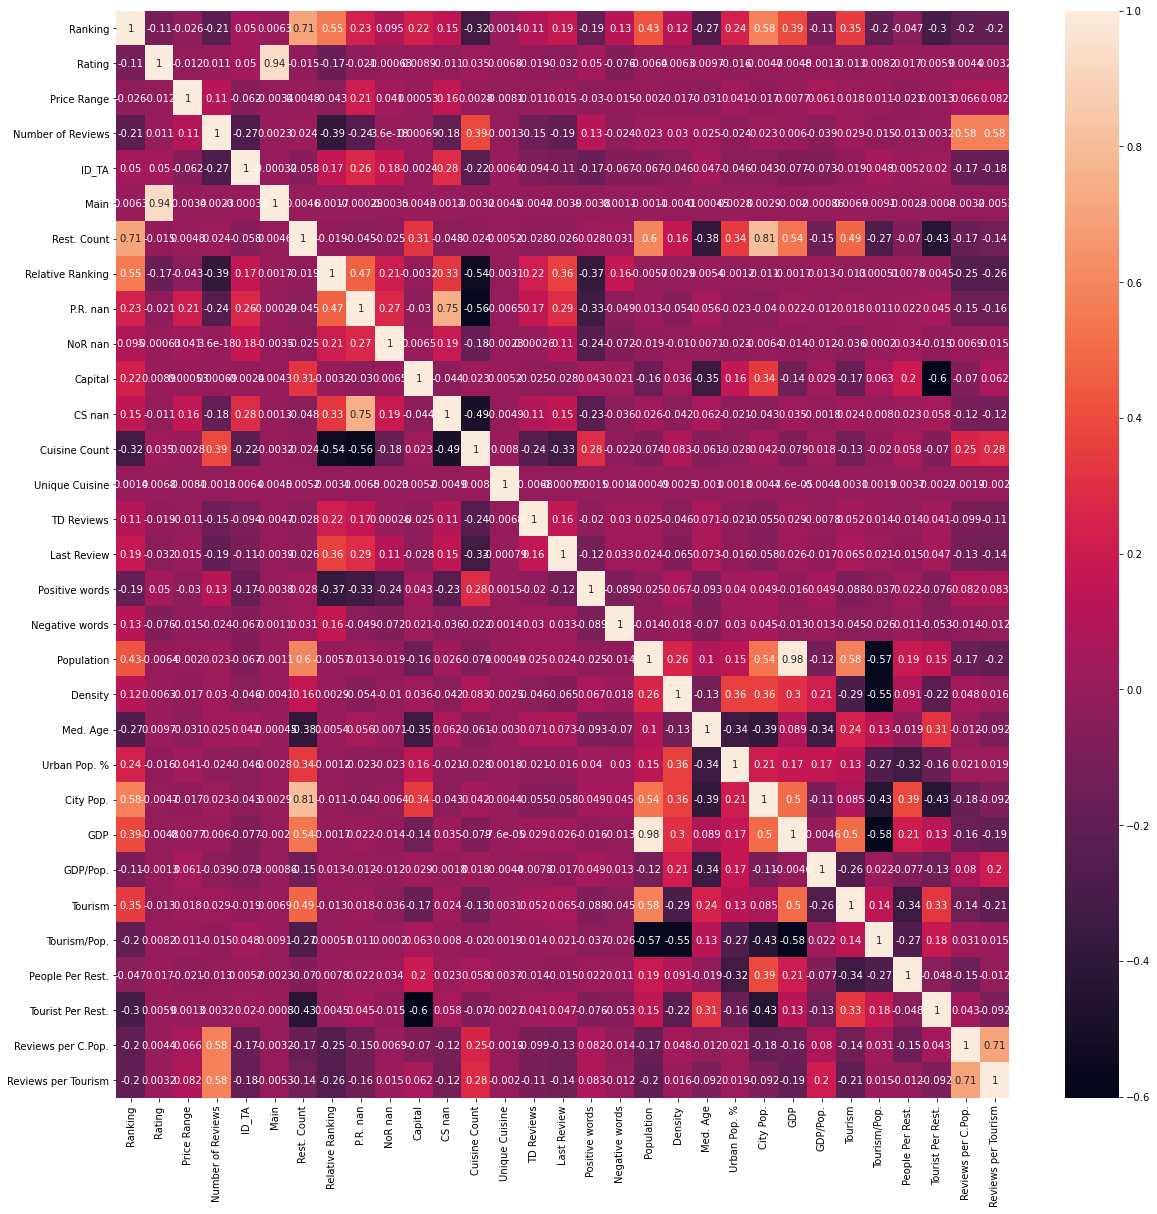

In [51]:
# Проверим корреляцию признаков
C = df.corr(method='pearson')
plt.figure(figsize = (20, 20)) # размер графика
sns.heatmap(data = C, annot = True)
# Видно, что 'GDP' очень сильно скоррелирован с 'Population'
# Параметры 'Rest. Count', 'City Pop.' и 'Ranking' также сильно скоррелилованы между собой

In [52]:
# Применим метод PCA для создания нового признака из 'GDP' и 'Population'
from sklearn.decomposition import PCA
A = pd.concat([df['GDP'], df['Population']], axis = 1)
pca = PCA(1)
pca.fit(A)
pca_1 = pca.transform(A)
pca_1

array([[ 9.70387392e+11],
       [-1.57943626e+12],
       [ 9.94445736e+11],
       ...,
       [ 4.30698870e+11],
       [ 4.30698870e+11],
       [ 9.70387392e+11]])

In [53]:
# Применим метод PCA для создания нового признака из 'Rest. Count', 'City Pop.' и 'Ranking'
from sklearn.decomposition import PCA
A = pd.concat([df['Rest. Count'], df['City Pop.'], df['Ranking']], axis = 1)
pca = PCA(1)
pca.fit(A)
pca_2 = pca.transform(A)
pca_2

array([[ -396670.57877235],
       [-1814141.01854946],
       [ 5532500.74801109],
       ...,
       [-1244289.63337823],
       [-1244290.98082233],
       [ -396669.51870196]])

In [54]:
# Добавляем полученные параметры к ДФ
df_pca = pd.DataFrame({'PCA_1': list(pca_1), 'PCA_2': list(pca_2)})
df_pca['PCA_1'] = df_pca['PCA_1'].apply(lambda x: x[0])
df_pca['PCA_2'] = df_pca['PCA_2'].apply(lambda x: x[0])
df_pca.head(3)

,PCA_1,PCA_2
0,9.703874e+11,-3.966706e+05
1,-1.579436e+12,-1.814141e+06
2,9.944457e+11,5.532501e+06


In [55]:
# Добавляем к ДФ
df = pd.concat([df, df_pca], axis = 1)
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,GDP,GDP/Pop.,Tourism,Tourism/Pop.,People Per Rest.,Tourist Per Rest.,Reviews per C.Pop.,Reviews per Tourism,PCA_1,PCA_2
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,3,194.0,good food at your doorstep a good hotel restau...,/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,...,3097061752487,47447.451578,89322,0.001368,361.245580,14.623772,0.000088,0.002172,9.703874e+11,-3.966706e+05
1,id_1535,Stockholm,[],1537.0,4.0,3,10.0,unique cuisine delicious nepalese food,/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,...,547238102912,54185.933621,10522,0.001042,763.818006,10.185866,0.000013,0.000950,-1.579436e+12,-1.814141e+06
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,5,688.0,catch up with friends not exceptional,/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,...,3121120096107,45975.894741,36316,0.000535,1131.053385,5.048797,0.000085,0.018945,9.944457e+11,5.532501e+06


# 12. Добавляем dummy-параметры

In [56]:
# Добавляем dummy-параметры городов
df_city = pd.get_dummies(df['City'])
df_city.head()

,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [57]:
# Создадим dummy-параметры для кухонь
# cuisine_set - множество типов кухонь, созданное в разделе 6.3
# Создаем функцию для определения наличия кухни в перечне
def Cuisine_dummy(data, cuisine):
    if cuisine in data:
        return 1
    else:
        return 0

# Создаем пустой ДФ, куда сохраним dummy-параметры о кухнях
df_cuisines = pd.DataFrame()

# Добавляем dummy-параметры
for cuisine in cuisine_set:
#    print(cuisine)
#    print(df['Cuisine Style'][0])
#    print(Cuisine_dummy(df['Cuisine Style'][0], cuisine))
    df_cuisines[cuisine] = df['Cuisine Style'].apply(lambda x: Cuisine_dummy(x, cuisine))

df_cuisines.head(3)

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0


# 13. Объединяем ДФ

In [58]:
# Объединяем в один ДФ
df_ml = pd.concat([df, df_city, df_cuisines], axis = 1)
df_ml.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,3,194.0,good food at your doorstep a good hotel restau...,/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,...,0,0,0,0,0,0,0,0,0,0
1,id_1535,Stockholm,[],1537.0,4.0,3,10.0,unique cuisine delicious nepalese food,/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,...,0,0,0,0,0,0,0,0,0,0
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,5,688.0,catch up with friends not exceptional,/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,...,0,0,1,1,0,0,0,0,0,0


In [59]:
df_ml.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA',
       ...
       'Ukrainian', 'Uzbek', 'Vegan Options', 'Vegetarian Friendly',
       'Venezuelan', 'Vietnamese', 'Welsh', 'Wine Bar', 'Xinjiang', 'Yunnan'],
      dtype='object', length=194)

In [60]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 194 entries, Restaurant_id to Yunnan
dtypes: bool(4), float64(16), int64(138), object(5), uint8(31)
memory usage: 62.3+ MB


# 13. Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [61]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df_ml[df_ml['Main'] == 1].drop(['Restaurant_id', 'City', 'Cuisine Style', 'Rating', 'GDP', 'Population',
             'Rest. Count', 'City Pop.', 'Ranking', 'Main', 'URL_TA', 'Reviews'], axis = 1)
y = df_ml[df_ml['Main'] == 1]['Rating']

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_seed)

# 14. Создаём, обучаем и тестируем модель

In [62]:
# Создаём модель
regr = RandomForestRegressor(n_estimators = 100, verbose = 1, n_jobs = -1, random_state = random_seed)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
MAE = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', MAE)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s


MAE: 0.198688


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [63]:
print(y_pred, df['Rating'].unique(), sep = '\n')
# В столце 'Rating' приведены значения с точностю 0.5, таким образом для повышения точности
# прогноза приозведем округление результатов модели

[4.4   4.93  4.23  ... 4.435 4.32  4.425]
[3.5 4.  4.5 5.  3.  2.5 2.  1.  1.5 0. ]


In [64]:
# Создадим функцию округления с точность 0.5
def rating_pred(y_pred):
    y = y_pred // 0.25
    if y % 2 == 0:
        return y * 0.25
    else:
        return (y + 1) * 0.25


# Произведем округление
for i in range(len(y_pred)):
    y_pred[i] = rating_pred(y_pred[i])

In [65]:
# Проверим точность определения рейтинга с учетом округления
MAE_round = metrics.mean_absolute_error(y_test, y_pred)
print(f'Достигнуто значение MAE: {MAE_round}')

Достигнуто значение MAE: 0.16415


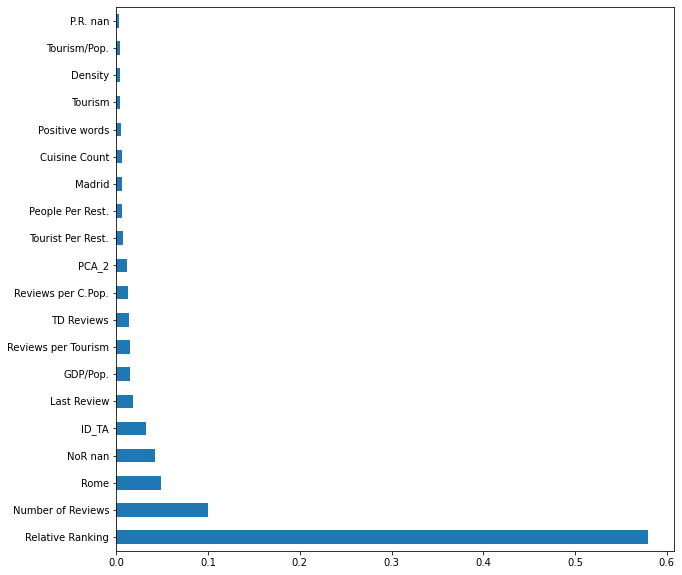

In [66]:
# Посмотрим на параметры, оказывающие наибольшее влияние на целевую переменную 
plt.figure(figsize = (10,10))
feat_importances = pd.Series(regr.feature_importances_, index = X.columns)
feat_importances.nlargest(20).plot(kind = 'barh')

In [67]:
# Создадим датафрейм с данными для передачи в модель для предсказания рейтингов
df_kt = df_ml[df_ml['Main'] == 0].drop(['Restaurant_id', 'City', 'Cuisine Style', 'Rating', 'GDP', 'Population',
             'Rest. Count', 'City Pop.', 'Ranking', 'Main', 'URL_TA', 'Reviews'], axis = 1)

In [68]:
df_kt_y_pred = regr.predict(df_kt)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [69]:
# Произведем округление
for i in range(len(df_kt_y_pred)):
    df_kt_y_pred[i] = rating_pred(df_kt_y_pred[i])

In [70]:
# Создадим датасет конечного результата submission_df
submission_df = pd.DataFrame()

In [71]:
# Запишем в него требуемые данные
submission_df['Restaurant_id'] = kt_data['Restaurant_id']
submission_df['Rating'] = df_kt_y_pred

In [72]:
submission_df

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.5


In [73]:
# Сохраним результат в файл
submission_df.to_csv('submission.csv', index = False)